## 19/03/2021 
 
Some more exploration is done with the various machine noises. 

This mainly involves trying to get the training to work properly with the various machine noises given. 

The model seems to get quite confused still. This could be due to the fact that i am directly feeding the model with various audio instead of letting it sample them by itself. 

However, this is difficult to do and will likely require some more exploration of the expectation maximisation algorithm and training using a combination of gradient descent and em algorithms. 

In [1]:
import torch 
import json 
import numpy as np 

# SubsetRandomSampler enables us to sample from the dataset. 
from sklearn.model_selection import train_test_split 

# dataloaders are good for not loading everything into memory and do it lazily
from torch.utils.data import SubsetRandomSampler, DataLoader,TensorDataset
from torch.autograd import Variable 

from tqdm import tqdm 
import torch.nn.functional as F
from torch import nn


In [2]:
DATA_PATH = "./data/synthetic/train_data.json"
VARIOUS_PATH = "./data/synthetic/various_data.json"

TEST_PATH = "./data/synthetic/test_data.json"
EPOCHS = 300
BATCH_SIZE = 150
SAVED_MODEL_PATH_E = "./models/model_paper_intermediate_E.pth"
SAVED_MODEL_PATH_D = "./models/model_paper_intermediate_D.pth"
SAVED_MODEL_PATH_G = "./models/model_paper_intermediate_G.pth"

In [3]:
def load_dataset(data_path):
    '''this loads the json file into dictionaries... still putting everything on memory '''
    with open(data_path,"r") as fp: 
        data = json.load(fp)
    X = np.array(data["data"])
    y = np.array(data["labels"])
    return X, y 

def to_device(data,device):
    ''' Loads everything to the GPU '''
    if isinstance(data, (list,tuple)):
        return [to_device(x, device)for x in data]
    else:
        return data.to(device, non_blocking = True)
    
class DeviceDataLoader():
    '''Creates a dataloader which automatically puts things to the device '''
    def __init__(self, dl, device):
        self.dl = dl 
        self.device = device 
    def __iter__(self):
        '''when used as an iterator this puts the batch onto the GPU before yielding it out'''
        for b in self.dl:
            yield to_device(b, self.device)
    def __len__(self):
        return len(self.dl)
    

# this is the training dataset containing only the normal sound samples
X,y=load_dataset(DATA_PATH)
X = torch.from_numpy(X).float()
y = torch.from_numpy(y).float()
dataset = TensorDataset(X,y)


# This contains various sounds, in this instance it is sound augmented by random dropping noises
X_v,y_v=load_dataset(VARIOUS_PATH)
X_v = torch.from_numpy(X_v).float()
y_v = torch.from_numpy(y_v).float()
dataset_v = TensorDataset(X_v,y_v)

# Test set contains normal sound samples, void sound samples at 1 snr and 0.5 snr.
X_test, y_test = load_dataset(TEST_PATH)
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()
testset = TensorDataset(X_test,y_test)

# Creating dataloaders from the datasets. 
train_dl = DataLoader(dataset, BATCH_SIZE, shuffle = True, drop_last=True)
test_dl = DataLoader(testset, BATCH_SIZE, shuffle = True, drop_last=True)
train_v_dl = DataLoader(dataset_v, BATCH_SIZE, shuffle = True, drop_last=True)

input_shape = dataset[0][0].shape
device = torch.device('cuda')

# decorating the dataloaders so that they load the data to the GPU automatically
train_dl = DeviceDataLoader(train_dl, device)
test_dl = DeviceDataLoader(test_dl, device)
train_v_dl = DeviceDataLoader(train_v_dl, device)

In [50]:
print(dataset_v[0])


(tensor([[[ -4.5665,  -4.2654,  -2.0106,  ...,  -7.3952, -30.4272, -14.4969],
         [ -6.3087,  -1.6650,  -4.4025,  ...,  -4.7651,  -8.7342, -11.2030],
         [-10.0447,   0.7506, -15.0677,  ...,  -2.3365,  -4.7488,  -8.5136],
         ...,
         [  7.1638,  14.0634,   6.9419,  ...,   1.2602,   6.0377,   3.9916],
         [  7.6228,  14.4680,   8.4123,  ...,   4.6743,   6.2258,   5.5481],
         [  7.7135,  16.0502,  15.1875,  ...,  10.8009,   9.3816,   9.7769]]]), tensor(0.))


In [44]:
latent_size = 9
# https://towardsdatascience.com/convolutional-autoencoders-for-image-noise-reduction-32fce9fc1763

class Encoder(nn.Module):
    '''Encoder is a convolutional'''
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1,32,stride = 2, padding=1 , kernel_size=3)
        self.relu = nn.LeakyReLU(0.2)
        self.conv2 = nn.Conv2d(32,64, stride = 2, padding =1, kernel_size=3)
        self.conv3 = nn.Conv2d(64,128,stride =2, padding =1, kernel_size = 3)
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(4096,latent_size)

    
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.relu(out)
        out = self.conv3(out)        
        out = self.relu(out)
        out = self.flatten(out)
        out1 = self.relu(self.linear(out))
        out2 = self.relu(self.linear(out))
        
        return out1, out2
    
def reparameterise(mu, log_var, training_mode):
    if training_mode:
        std = torch.exp(0.5*log_var)
        eps = Variable(std.data.new(std.size()).normal_())
        sample = mu + (eps*std)
        return sample 
    else:
        return mu 
    
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Linear(latent_size,4096)
        self.relu = nn.LeakyReLU(0.2)

        self.deconv3 = nn.ConvTranspose2d(128,64,stride =2, kernel_size = 3, padding =1,output_padding=1)
        self.deconv2 = nn.ConvTranspose2d(64,32,stride =2, kernel_size = 3,padding =1,output_padding=1)
        self.deconv1 = nn.ConvTranspose2d(32,1,stride =2, kernel_size = 3,padding =1,output_padding=1)
        
    def forward(self, xb):
        out = self.fc(xb)
        out = self.relu(out)
        out = out.reshape(-1,128,16,2)
        out = self.deconv3(out)
        out = self.relu(out)
        out = self.deconv2(out)
        out = self.relu(out)
        out = self.deconv1(out)
        return out

E_module = Encoder()
G_module = Decoder()
D_module = Decoder()

E_module.to(device)
G_module.to(device)
D_module.to(device)
#E_module.load_state_dict(torch.load(SAVED_MODEL_PATH_E))
#G_module.load_state_dict(torch.load(SAVED_MODEL_PATH_D))
#D_module.load_state_dict(torch.load(SAVED_MODEL_PATH_G))

Decoder(
  (fc): Linear(in_features=9, out_features=4096, bias=True)
  (relu): LeakyReLU(negative_slope=0.2)
  (deconv3): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (deconv2): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (deconv1): ConvTranspose2d(32, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
)

In [45]:
from torchsummary import summary 
print(summary(E_module, input_size = (1,128,16)))
print(summary(G_module, input_size = (1,9)))
print(summary(D_module, input_size = (1,9)))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 32, 64, 8]             320
         LeakyReLU-2            [-1, 32, 64, 8]               0
            Conv2d-3            [-1, 64, 32, 4]          18,496
         LeakyReLU-4            [-1, 64, 32, 4]               0
            Conv2d-5           [-1, 128, 16, 2]          73,856
         LeakyReLU-6           [-1, 128, 16, 2]               0
           Flatten-7                 [-1, 4096]               0
            Linear-8                    [-1, 9]          36,873
         LeakyReLU-9                    [-1, 9]               0
           Linear-10                    [-1, 9]          36,873
        LeakyReLU-11                    [-1, 9]               0
Total params: 166,418
Trainable params: 166,418
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/

spectrogram shape:  torch.Size([150, 1, 128, 16])
output shape:  torch.Size([150, 9])
torch.Size([150, 9])


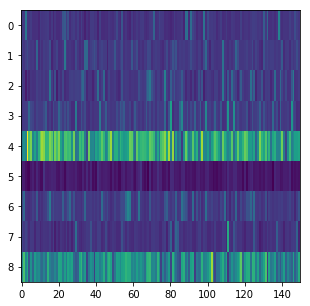

In [46]:

for images, labels in test_dl: 
    print("spectrogram shape: ", images.shape)
    out, _ = E_module(images)
    
    print("output shape: ", out.shape)
    break 
    
img = out.detach().cpu()
print(img.shape)
import matplotlib.pyplot as plt 

fig, ax = plt.subplots(1,1,figsize = (5,5))
ax.imshow(img.T, aspect = 'auto')


In [47]:



def loss_function(images, reconstructed, mu,logvar):
    mse = nn.MSELoss()
    mse_loss = mse(images,reconstructed)
    
    KLD = -0.5*torch.sum(1+logvar - mu.pow(2) - logvar.exp())/(BATCH_SIZE*128*16)
    return KLD+mse_loss

# The np loss is defined as the TPR minus the FPR. We cannot compute this exactly in an efficient manner so we can instead 
def NP_loss(images_u, reconstructed_u, images_a, reconstructed_a, phi):
    mse1 = nn.MSELoss(reduction ="none")
    m_a = torch.mean(mse1(images_a, reconstructed_a), dim =(1,2,3))
    m_u = torch.mean(mse1(images_u, reconstructed_u), dim =(1,2,3))
    #print(m_a,m_u, phi)
    tpr = torch.mean(torch.sigmoid(m_a-phi))
    fpr = torch.mean(torch.sigmoid(m_u-phi))
    return fpr - tpr 
    

## Now start training and see what the resulting image would look like 


In [48]:
e_opt= torch.optim.Adam(E_module.parameters(), lr = 0.0002)
d_opt= torch.optim.Adam(D_module.parameters(), lr = 0.0002)
g_opt= torch.optim.Adam(G_module.parameters(), lr = 0.0002)





In [61]:
loss_list = []
EPOCHS = 2
mse = nn.MSELoss(reduction = "none")

for epoch in range(EPOCHS):
    for (images, _),(images_v, _v) in zip(train_dl,train_v_dl):
        mu, logvar = E_module(images_v)
        z = reparameterise(mu, logvar, True)
        print(z)
        reconstructed_a = G_module(z)
        temp = reconstructed_a.clone()

        loss = loss_function(images_v, reconstructed_a, mu, logvar)
        
        e_opt.zero_grad()
        g_opt.zero_grad()
        loss.backward()
        e_opt.step()
        g_opt.step()
    
    
        # Now do the second training step 
        reconstructed_a = temp.detach()
        
        latents, _ = E_module(images)
        recon_normal = D_module(latents)

        latents_anomalous, _= E_module(reconstructed_a)
        recon_anomalous = D_module(latents_anomalous)

        
        phi = min(torch.mean(mse(reconstructed_a.clone(), recon_anomalous.clone()), dim =(1,2,3)))
        
        loss_np = NP_loss(images, recon_normal, reconstructed_a, recon_anomalous, phi)
        
        e_opt.zero_grad()
        d_opt.zero_grad()
        loss_np.backward()
        e_opt.step()
        d_opt.step()
           
        
    loss_list.append(np.sum(loss.item()))
    
    print('epoch [{}/{}], loss:{:.4f}, loss_np{:.4f}'.format(epoch+1, EPOCHS, loss.item(), loss_np.item()))

        


tensor([[ -3.9119, -12.4597,  -7.3440,  ..., -14.4635,  -6.0767,  -6.1028],
        [ -0.7346, -16.3336,  -7.4501,  ..., -11.0450,  -6.9909,  -0.8110],
        [ -3.7025,  -9.9477,  -2.5593,  ..., -12.9495,  -1.9901, -16.2536],
        ...,
        [-10.7789, -12.2838,  -6.8420,  ..., -11.3945,  -8.7450, -13.4908],
        [ -1.6777, -18.6367,  -6.4081,  ..., -13.7562,  -7.2842,  -4.6021],
        [ -7.6906,  -3.9098,  -7.1051,  ..., -14.1099,  -6.0468, -14.8634]],
       device='cuda:0', grad_fn=<AddBackward0>)
tensor([[ -9.8619,  -7.9812,  -4.2623,  ..., -10.5653,  -5.4396, -11.4288],
        [-10.3673,  -8.2504,  -3.9662,  ..., -15.8695,  -6.1873,  -3.3586],
        [-11.6603,  -9.3123,  -4.8465,  ..., -10.6884,  -5.8609,  -8.4861],
        ...,
        [-21.0366,  -4.5123,  -2.8045,  ..., -11.8489,  -3.3020,  -5.1895],
        [-16.2500, -11.7558,  -7.7453,  ..., -11.4145,  -8.2429, -10.2950],
        [ -9.5834,  -5.2621,  -6.4274,  ..., -12.0731,  -6.1062, -16.2110]],
       devic

In [33]:
torch.save(E_module.state_dict(), SAVED_MODEL_PATH_E)
torch.save(D_module.state_dict(), SAVED_MODEL_PATH_D)
torch.save(G_module.state_dict(), SAVED_MODEL_PATH_G)



spectrogram shape:  torch.Size([150, 1, 128, 16])
output shape:  torch.Size([150, 1, 128, 16])
torch.Size([128, 16])


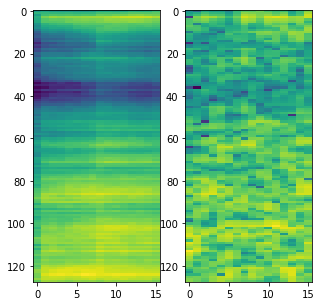

In [53]:

for images, labels in train_dl: 
    print("spectrogram shape: ", images.shape)
    mu, logvar = E_module(images)
    z = reparameterise(mu, logvar, False)

    out = G_module(z)    
    print("output shape: ", out.shape)
    break 
    
img = out[1][0].detach().cpu()
print(img.shape) 

import matplotlib.pyplot as plt 
fig, axs = plt.subplots(1,2,figsize = (5,5))
axs[0].imshow(img, aspect = 'auto')
axs[1].imshow(images[1][0].detach().cpu(), aspect = 'auto')

In [54]:
out_list = [[] for i in range(3)]
imgs = [[] for i in range(3)]
mse_per_image = nn.MSELoss(reduction='none')
for images, labels in test_dl:
    print(images.shape)
    mu, logvar = E_module(images)
    z = reparameterise(mu, logvar, False) 
    out = G_module(z)    
    losses = torch.sum(mse_per_image(images, out).detach().cpu(), dim =(1,2,3))/(images.shape[-1]*images.shape[-2])
    losses = losses.numpy()
    for i in range(len(images)):
        out_list[int(labels[i].detach().cpu())].append(losses[i])
        imgs[int(labels[i].detach().cpu())].append(images[i])


torch.Size([150, 1, 128, 16])
torch.Size([150, 1, 128, 16])
torch.Size([150, 1, 128, 16])
torch.Size([150, 1, 128, 16])


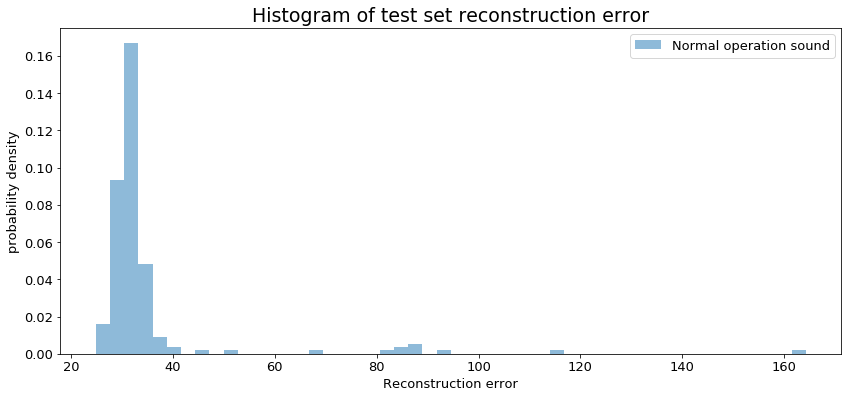

torch.Size([1, 128, 16])


In [63]:

fig, ax = plt.subplots(1,1,figsize = (14,6))

ax.title.set_text("Histogram of test set reconstruction error")
ax.title.set_fontsize(19)
labels = ["Normal operation sound", "Snr = 1.0", "Snr = 0.5"]

for i in range(1):
    ax.hist(bins = 50, x=out_list[i], alpha = 0.5, label = labels[i], density = True)

ax.set_xlabel("Reconstruction error")
ax.set_ylabel("probability density")
ax.legend()
plt.show()

min_img = imgs[1][out_list[1].index(min(out_list[1]))]
print(np.shape(min_img))


## analysis 
the performance in this case got a lot worse. looking at the shape of the normal sound reconstruction error, we can see that the distribution became not very normal, with a large amount of outliers. The part around 30 seems to be more steep. This means for at least a certain group of inputs, the output became more confident that the sound is normal. However, for perhaps the part of the normal sound that sounded like the generated positive case, this broke down as the training procedure now confuses the model to reconstruct the these according to the similar positive examples seen during training. This could be due to a low snr on when constructing these training positves, meaning they were not suffuciently different from the normal sound. Increasing the 

torch.Size([1, 128, 16])
torch.Size([128, 16])


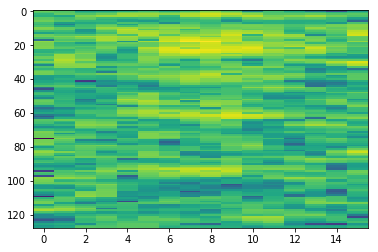

In [57]:
min_img = imgs[1][out_list[1].index(min(out_list[1]))]
print(np.shape(min_img))
im = min_img.detach().cpu().squeeze()
print(np.shape(im))
plt.imshow(im, aspect = "auto")

The difference is 0.4464516878622635


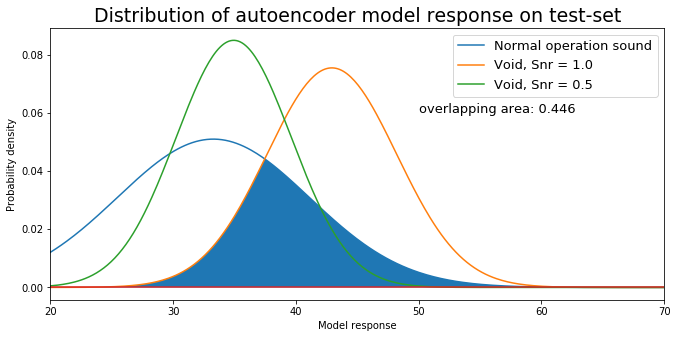

In [58]:
import scipy.integrate
from scipy.stats import norm
fig, ax = plt.subplots(1,1,figsize = (11,5))
integrate = scipy.integrate.quad
ax.title.set_text("Distribution of autoencoder model response on test-set")
ax.title.set_fontsize(19)
labels = ["Normal operation sound", "Void, Snr = 1.0", "Void, Snr = 0.5"]
x = np.linspace(20,140,800)
SMALL_SIZE = 13
MEDIUM_SIZE = 13
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
 
for i in range(len(out_list)):
    truncated = [out_list[i][j] if out_list[i][j]<=65 else 65 for j in range(len(out_list[i]))]
    if i ==1: 
        m_old = m
        s_old = s
        y_old = y
    m = np.mean(truncated)
    s = np.sqrt(np.var(truncated))
    y = norm.pdf(x,m,s)

    if i==1:
        under_fun = lambda x: min(norm.pdf(x,m,s), norm.pdf(x,m_old, s_old))
        diff = integrate(under_fun, 10,60)
        print(f"The difference is {diff[0]}")
        y_min = [min(y[i],y_old[i]) for i in range(len(y))]
        ax.fill_between(x, y_min)
    ax.plot(x,y, label = labels[i])
    


ax.plot(x, [0 for i in range(len(x))])
ax.set_xlim([20,70])
ax.set_xlabel("Model response")
ax.set_ylabel("Probability density")
ax.text(50,0.06,f"overlapping area: {diff[0]:.3f}")
ax.legend()
plt.show()


The aoc score is 0.931 for snr =1
The aoc score is 0.732 for snr =0.5


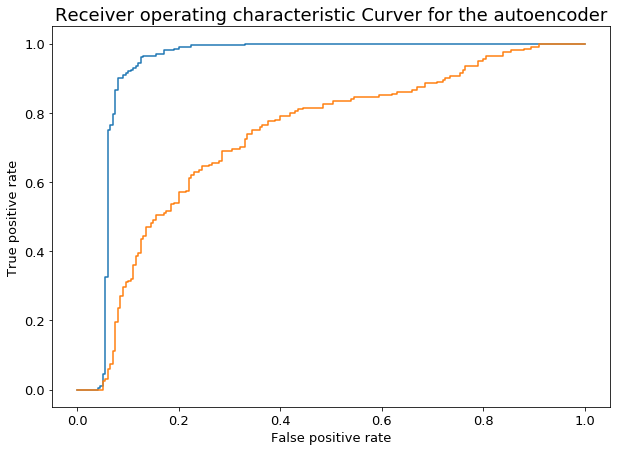

In [59]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import pickle 
scores1 = out_list[0]+out_list[1]
y1 = [0 for i in range(len(out_list[0]))]+[1 for i in range(len(out_list[1]))]
fpr1, tpr1, thresholds1 = roc_curve(y1, scores1, pos_label = 1)

aoc_snr1 = roc_auc_score(y1,scores1)
print(f"The aoc score is {aoc_snr1:.3f} for snr =1")

scores2 = out_list[0]+out_list[2]
y2 = [0 for i in range(len(out_list[0]))]+[1 for i in range(len(out_list[2]))]
fpr2, tpr2, thresholds2= roc_curve(y2, scores2, pos_label = 1)

aoc_snr2 = roc_auc_score(y2,scores2)
print(f"The aoc score is {aoc_snr2:.3f} for snr =0.5")

with open("auto_roc.txt", "wb") as f: 
    pickle.dump({"fpr1":fpr1, "tpr1":tpr1, "thresholds1":thresholds1,"fpr2":fpr2, "tpr2":tpr2, "thresholds2":thresholds2
                , "scores1": scores1, "scores2": scores2, "y1": y1, "y2":y2},f)

fig, ax = plt.subplots(1,1, figsize = (10,7))

ax.title.set_text("Receiver operating characteristic Curver for the autoencoder")
ax.set_xlabel("False positive rate")
ax.set_ylabel("True positive rate")
ax.plot(fpr1, tpr1)
ax.plot(fpr2, tpr2)

In [81]:
import librosa

test_piece, sr = librosa.load("./data/synthetic/7_with_void.wav")

score = []
i =0 
my_len = 16*512-1
while i<len(test_piece)-my_len:
    piece = test_piece[i:i+my_len]
    xt  = librosa.power_to_db(librosa.feature.melspectrogram(piece, n_mels = 128, fmax = 1024))
    xt = torch.tensor(xt).float()
    xt = torch.unsqueeze(xt,0)
    xt = torch.unsqueeze(xt,0)
    xt = xt.to(device)
    mu, logvar = E_module(xt)
    z = reparameterise(mu, logvar, False)

    out = G_module(z)        
    loss = mse_per_image(out, xt)
    
    score.append(float(torch.sum(loss.detach().cpu())/(xt.shape[-1]*xt.shape[-2])))
    i+= 512
    


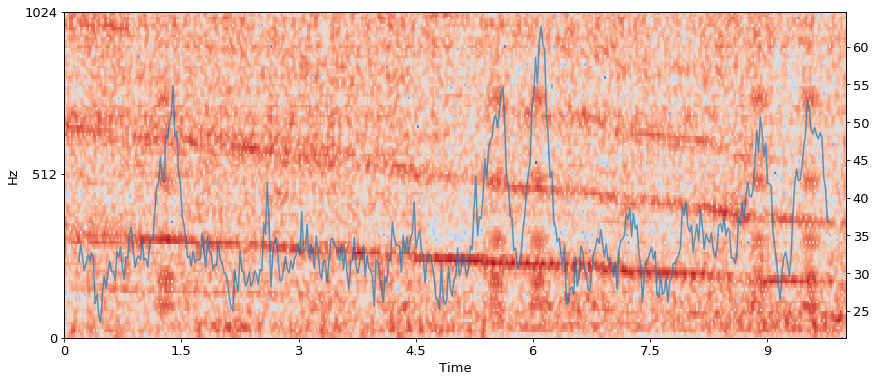

In [82]:
import librosa.display
x =[]
test_xt = librosa.power_to_db(librosa.feature.melspectrogram(test_piece, n_mels =128, fmax= 1024))
fig = plt.gcf()
fig.set_size_inches(14,6)
ax = plt.subplot()

ax2 = ax.twinx()
librosa.display.specshow(test_xt, fmax = 1024, y_axis = "mel", ax = ax, x_axis = 'time')
for i in range(len(score)):
    x.append((i+8)*(512/sr))
ax2.plot(x,score, alpha = 0.7)

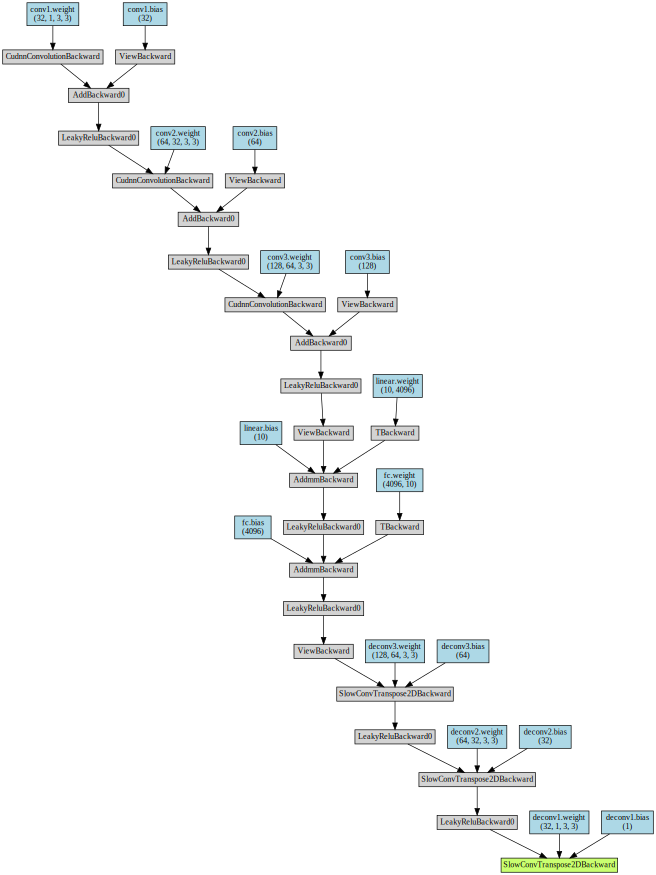

In [161]:
from torchviz import make_dot 
make_dot(recons, params = dict(autoencoder.named_parameters()))

In [163]:
from torch.utils.tensorboard import SummaryWriter 
writer = SummaryWriter("runs/ae_experiment_1")

In [169]:
writer.add_graph(autoencoder,images)


In [17]:
(0.98**2*0.03)/(0.04**2*0.97+0.03*0.98**2)

0.9488868396785667